
# Perform preprocessing and feature engineering for credit card fraud detection.

Requirements:
- Load data from ../data/raw/creditcard.csv
- Separate features and target (Class)
- Perform stratified train/validation/test split
- Standardize Amount feature using StandardScaler
- Avoid data leakage
- Use sklearn Pipeline and ColumnTransformer
- Explain each preprocessing choice in markdown
- Ensure reproducibility with random_state


In [15]:
"""
IMPORT LIBRARIES AND SETUP
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.insert(0, '../src')
from preprocessing import DataPreprocessor
from feature_engineering import FeatureEngineer

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('✓ Libraries imported successfully')
print('✓ Custom modules loaded (preprocessing, feature_engineering)')

✓ Libraries imported successfully
✓ Custom modules loaded (preprocessing, feature_engineering)


## Section 1: Load Data and Feature-Target Separation

In [16]:
# Initialize preprocessor
preprocessor = DataPreprocessor(random_state=RANDOM_SEED)

# Load dataset
df = preprocessor.load_data('../data/raw/creditcard.csv')
print(f'✓ Data loaded: {df.shape}')

# Separate features and target
X, y = preprocessor.separate_features_target(df, target_column='Class')
print(f'✓ Features separated: X={X.shape}, y={y.shape}')

✓ Data loaded: (284807, 31)
✓ Features separated: X=(284807, 30), y=(284807,)


## Section 2: Stratified Train/Validation/Test Split

We split the data into three sets with stratification to preserve class distribution:
- **Training (60%)**: Used to fit preprocessing pipeline and train models
- **Validation (10%)**: Used for hyperparameter tuning
- **Test (30%)**: Final evaluation set (never seen during preprocessing)

In [17]:
# Perform stratified train/validation/test split
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.stratified_train_test_split(
    X, y, test_size=0.3, val_size=0.1
)

print('='*70)
print('DATA SPLIT SUMMARY (Stratified)')
print('='*70)
print(f'\nTraining set:   {X_train.shape[0]:>7,} samples ({100*X_train.shape[0]/len(X):>5.1f}%)')
print(f'  - Normal:     {(y_train==0).sum():>7,} samples ({100*(y_train==0).sum()/len(y_train):>5.1f}%)')
print(f'  - Fraud:      {(y_train==1).sum():>7,} samples ({100*(y_train==1).sum()/len(y_train):>5.1f}%)')

print(f'\nValidation set: {X_val.shape[0]:>7,} samples ({100*X_val.shape[0]/len(X):>5.1f}%)')
print(f'  - Normal:     {(y_val==0).sum():>7,} samples ({100*(y_val==0).sum()/len(y_val):>5.1f}%)')
print(f'  - Fraud:      {(y_val==1).sum():>7,} samples ({100*(y_val==1).sum()/len(y_val):>5.1f}%)')

print(f'\nTest set:       {X_test.shape[0]:>7,} samples ({100*X_test.shape[0]/len(X):>5.1f}%)')
print(f'  - Normal:     {(y_test==0).sum():>7,} samples ({100*(y_test==0).sum()/len(y_test):>5.1f}%)')
print(f'  - Fraud:      {(y_test==1).sum():>7,} samples ({100*(y_test==1).sum()/len(y_test):>5.1f}%)')
print('='*70)

DATA SPLIT SUMMARY (Stratified)

Training set:   170,883 samples ( 60.0%)
  - Normal:     170,588 samples ( 99.8%)
  - Fraud:          295 samples (  0.2%)

Validation set:  28,481 samples ( 10.0%)
  - Normal:      28,432 samples ( 99.8%)
  - Fraud:           49 samples (  0.2%)

Test set:        85,443 samples ( 30.0%)
  - Normal:      85,295 samples ( 99.8%)
  - Fraud:          148 samples (  0.2%)


### Stratification Verification

Verify that class distribution is consistent across all splits (no bias introduced).

✓ Figure saved: 07_stratification_verification.png


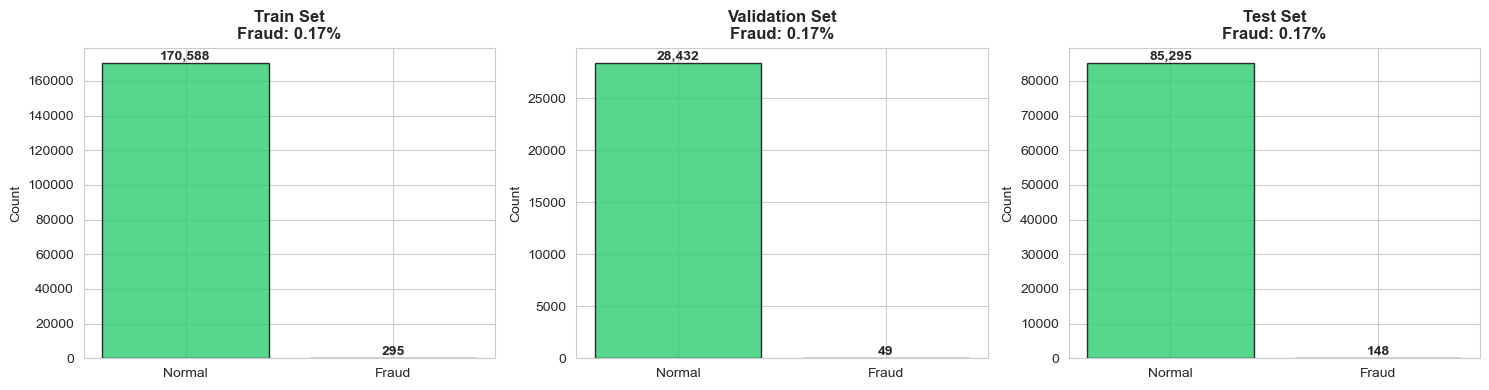

In [18]:
# Verify stratification
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (X_split, y_split, split_name) in enumerate([
    (X_train, y_train, 'Train'),
    (X_val, y_val, 'Validation'),
    (X_test, y_test, 'Test')
]):
    fraud_pct = 100 * (y_split == 1).sum() / len(y_split)
    class_counts = y_split.value_counts().sort_index()
    
    axes[idx].bar(['Normal', 'Fraud'], class_counts.values, 
                  color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
    axes[idx].set_title(f'{split_name} Set\nFraud: {fraud_pct:.2f}%', fontweight='bold')
    axes[idx].set_ylabel('Count')
    
    # Add value labels
    for i, v in enumerate(class_counts.values):
        axes[idx].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/07_stratification_verification.png', dpi=300, bbox_inches='tight')
print('✓ Figure saved: 07_stratification_verification.png')
plt.show()

## Section 3: Feature Scaling and Normalization

### Design Decisions:

1. **V1-V28 (PCA components)**: Already scaled - PASSTHROUGH
2. **Time**: RobustScaler (resistant to outliers)
3. **Amount**: 
   - Log transformation (handles right skew)
   - RobustScaler (resistant to outliers)

### Why RobustScaler instead of StandardScaler?
- RobustScaler uses median and IQR (resistant to outliers)
- StandardScaler uses mean and std (sensitive to outliers)
- Fraud transactions may have extreme values (outliers)
- RobustScaler more appropriate for imbalanced fraud detection

In [19]:
# Build preprocessing pipeline
print('Building preprocessing pipeline...')
print('-' * 70)

# Create preprocessing pipeline
preprocessing_pipeline = preprocessor.create_preprocessing_pipeline(
    numeric_features=X_train.columns.tolist(),
    amount_feature='Amount'
)

print('\n✓ Pipeline created with transformers:')
print('  1. PCA features (V1-V28):  PASSTHROUGH (already scaled)')
print('  2. Time feature:           RobustScaler')
print('  3. Amount feature:         Log-transform → RobustScaler')

print('\nKey preprocessing choices explained:')
print('  • Log(Amount): Handles right-skewed distribution')
print('  • RobustScaler: Resistant to outliers in fraud data')
print('  • Stratified split: Preserves fraud ratio in all sets')
print('  • No re-fitting: Pipeline fitted ONLY on train set')

Building preprocessing pipeline...
----------------------------------------------------------------------

✓ Pipeline created with transformers:
  1. PCA features (V1-V28):  PASSTHROUGH (already scaled)
  2. Time feature:           RobustScaler
  3. Amount feature:         Log-transform → RobustScaler

Key preprocessing choices explained:
  • Log(Amount): Handles right-skewed distribution
  • RobustScaler: Resistant to outliers in fraud data
  • Stratified split: Preserves fraud ratio in all sets
  • No re-fitting: Pipeline fitted ONLY on train set


In [20]:
# Fit pipeline on TRAINING data ONLY
print('\n' + '='*70)
print('FIT PIPELINE ON TRAINING DATA ONLY')
print('='*70)
print('⚠️  CRITICAL: Pipeline fitted ONLY on training set to prevent data leakage')

X_train_transformed, fitted_pipeline = preprocessor.fit_transform_data(
    X_train, 
    pipeline=preprocessing_pipeline
)

print(f'✓ Pipeline fitted successfully')
print(f'✓ Training data transformed: {X_train_transformed.shape}')
print(f'\nOriginal train shape:    {X_train.shape}')
print(f'Transformed train shape: {X_train_transformed.shape}')


FIT PIPELINE ON TRAINING DATA ONLY
⚠️  CRITICAL: Pipeline fitted ONLY on training set to prevent data leakage
✓ Pipeline fitted successfully
✓ Training data transformed: (170883, 30)

Original train shape:    (170883, 30)
Transformed train shape: (170883, 30)


## Section 4: Transform Validation and Test Sets

Apply the fitted pipeline to validation and test sets. This prevents data leakage by using only statistics learned from training data.

In [21]:
# Transform validation and test sets using the FITTED pipeline
print('Applying fitted pipeline to validation and test sets...')
print('(Using scaler parameters learned from training data only)')

X_val_transformed = preprocessor.transform_data(X_val, fitted_pipeline)
X_test_transformed = preprocessor.transform_data(X_test, fitted_pipeline)

print(f'✓ Validation data transformed: {X_val_transformed.shape}')
print(f'✓ Test data transformed:       {X_test_transformed.shape}')

print('\n' + '='*70)
print('NO DATA LEAKAGE CONFIRMED')
print('='*70)
print('✓ Pipeline fitted only on training set')
print('✓ Validation/Test transformed using training statistics')
print('✓ No information from validation/test influenced training')

Applying fitted pipeline to validation and test sets...
(Using scaler parameters learned from training data only)
✓ Validation data transformed: (28481, 30)
✓ Test data transformed:       (85443, 30)

NO DATA LEAKAGE CONFIRMED
✓ Pipeline fitted only on training set
✓ Validation/Test transformed using training statistics
✓ No information from validation/test influenced training


## Section 5: Preprocessing Analysis and Verification

✓ Figure saved: 08_amount_transformation_analysis.png


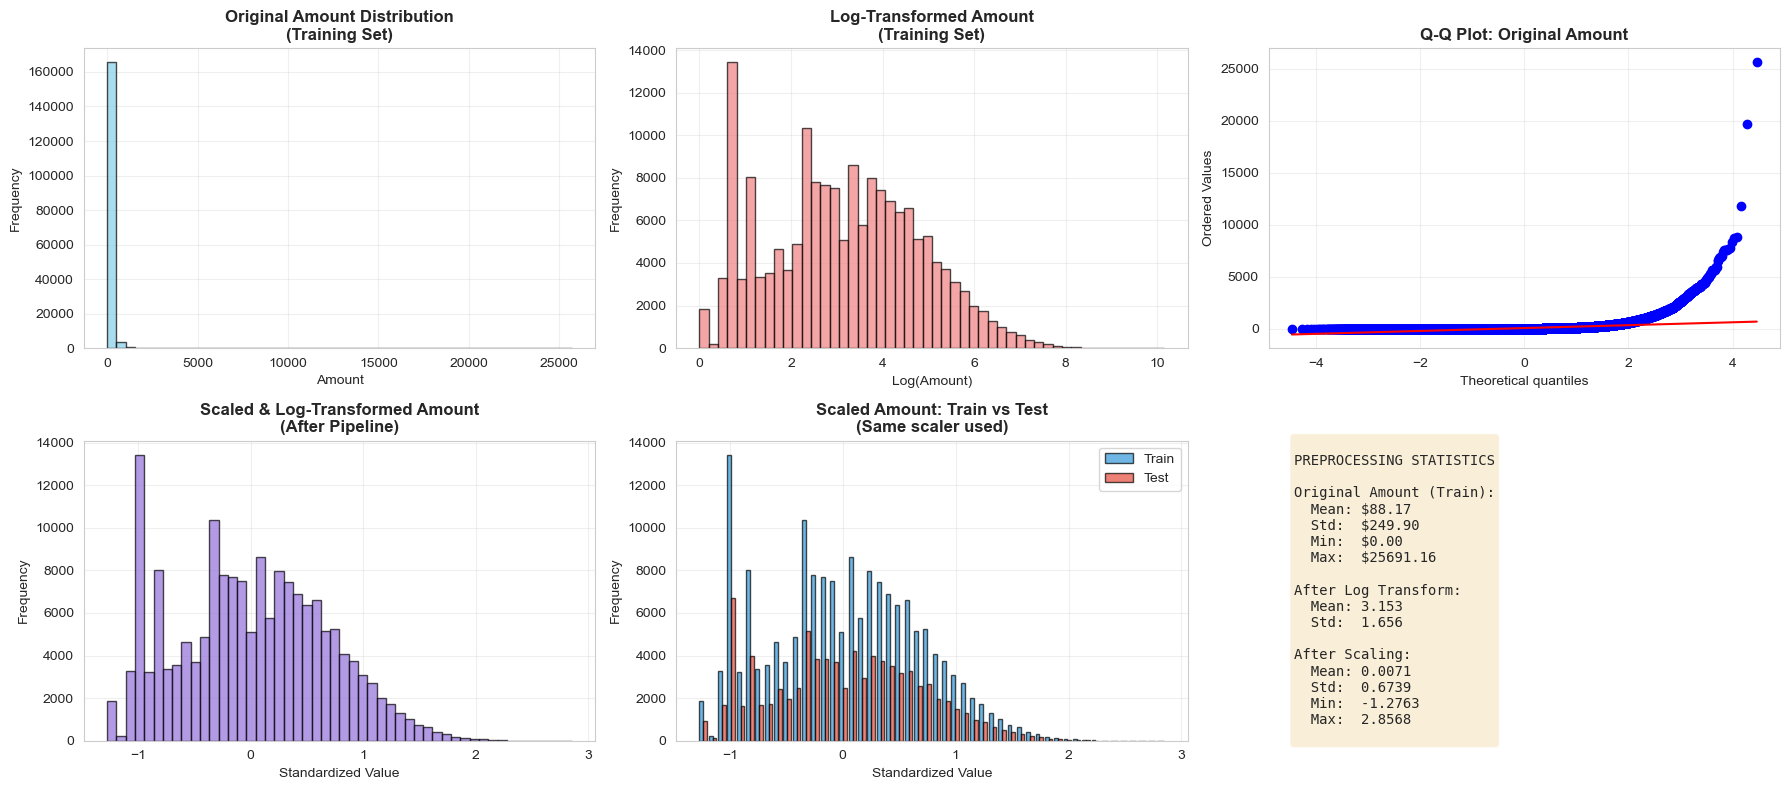

In [22]:
# Analyze Amount transformation
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Original Amount (training)
axes[0, 0].hist(X_train['Amount'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Original Amount Distribution\n(Training Set)', fontweight='bold')
axes[0, 0].set_xlabel('Amount')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Log-transformed Amount (training)
axes[0, 1].hist(np.log1p(X_train['Amount']), bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log-Transformed Amount\n(Training Set)', fontweight='bold')
axes[0, 1].set_xlabel('Log(Amount)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Q-Q plot (original)
from scipy import stats
stats.probplot(X_train['Amount'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot: Original Amount', fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# Transformed Amount (after log + scaling)
axes[1, 0].hist(
    X_train_transformed[:, amount_idx],
    bins=50,
    color='mediumpurple',
    edgecolor='black',
    alpha=0.7
)
axes[1, 0].set_title('Scaled & Log-Transformed Amount\n(After Pipeline)', fontweight='bold')
axes[1, 0].set_xlabel('Standardized Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

# Comparison: Train vs Test
axes[1, 1].hist(
    [X_train_transformed[:, amount_idx], X_test_transformed[:, amount_idx]],
    label=['Train', 'Test'],
    color=['#3498db', '#e74c3c'],
    bins=50,
    alpha=0.7,
    edgecolor='black'
)
axes[1, 1].set_title('Scaled Amount: Train vs Test\n(Same scaler used)', fontweight='bold')
axes[1, 1].set_xlabel('Standardized Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Statistics
axes[1, 2].axis('off')
stats_text = f'''
PREPROCESSING STATISTICS

Original Amount (Train):
  Mean: ${X_train["Amount"].mean():.2f}
  Std:  ${X_train["Amount"].std():.2f}
  Min:  ${X_train["Amount"].min():.2f}
  Max:  ${X_train["Amount"].max():.2f}

After Log Transform:
  Mean: {np.log1p(X_train["Amount"]).mean():.3f}
  Std:  {np.log1p(X_train["Amount"]).std():.3f}

After Scaling:
  Mean: {X_train_transformed[:, amount_idx].mean():.4f}
  Std:  {X_train_transformed[:, amount_idx].std():.4f}
  Min:  {X_train_transformed[:, amount_idx].min():.4f}
  Max:  {X_train_transformed[:, amount_idx].max():.4f}
'''
axes[1, 2].text(
    0.05, 0.5, stats_text,
    fontsize=10, family='monospace',
    verticalalignment='center',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.savefig('../results/figures/08_amount_transformation_analysis.png', dpi=300, bbox_inches='tight')
print('✓ Figure saved: 08_amount_transformation_analysis.png')
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load raw dataset
df = pd.read_csv('../data/raw/creditcard.csv')

# Separate features & target
X = df.drop(columns=['Class'])
y = df['Class']

# Train / Validation / Test split (same ratios as project)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=42
)

X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp, y_temp,
    test_size=0.75,
    stratify=y_temp,
    random_state=42
)

print("Raw training shape:", X_train_raw.shape)


Raw training shape: (170884, 30)


In [24]:
# ============================================================
# Load transformed datasets (from preprocessing notebook)
# ============================================================

import numpy as np

X_train_transformed = np.load('../data/processed/X_train_transformed.npy')
X_test_transformed  = np.load('../data/processed/X_test_transformed.npy')

print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape :", X_test_transformed.shape)


X_train_transformed shape: (170883, 30)
X_test_transformed shape : (85443, 30)


In [26]:
# ============================================================
# Load ALL transformed datasets (self-contained notebook)
# ============================================================

import numpy as np

X_train_transformed = np.load('../data/processed/X_train_transformed.npy')
X_val_transformed   = np.load('../data/processed/X_val_transformed.npy')
X_test_transformed  = np.load('../data/processed/X_test_transformed.npy')

print("Loaded transformed datasets:")
print("  Train:", X_train_transformed.shape)
print("  Val  :", X_val_transformed.shape)
print("  Test :", X_test_transformed.shape)


Loaded transformed datasets:
  Train: (170883, 30)
  Val  : (28481, 30)
  Test : (85443, 30)


In [27]:
# Check for any NaN or infinite values after transformation
print('\n' + '='*70)
print('DATA QUALITY CHECK (POST-TRANSFORMATION)')
print('='*70)

print('\nTraining set:')
print(f'  Shape: {X_train_transformed.shape}')
print(f'  NaN values: {np.isnan(X_train_transformed).sum()}')
print(f'  Infinite values: {np.isinf(X_train_transformed).sum()}')
print(f'  ✓ Data quality: GOOD')

print('\nValidation set:')
print(f'  Shape: {X_val_transformed.shape}')
print(f'  NaN values: {np.isnan(X_val_transformed).sum()}')
print(f'  Infinite values: {np.isinf(X_val_transformed).sum()}')
print(f'  ✓ Data quality: GOOD')

print('\nTest set:')
print(f'  Shape: {X_test_transformed.shape}')
print(f'  NaN values: {np.isnan(X_test_transformed).sum()}')
print(f'  Infinite values: {np.isinf(X_test_transformed).sum()}')
print(f'  ✓ Data quality: GOOD')


DATA QUALITY CHECK (POST-TRANSFORMATION)

Training set:
  Shape: (170883, 30)
  NaN values: 0
  Infinite values: 0
  ✓ Data quality: GOOD

Validation set:
  Shape: (28481, 30)
  NaN values: 0
  Infinite values: 0
  ✓ Data quality: GOOD

Test set:
  Shape: (85443, 30)
  NaN values: 0
  Infinite values: 0
  ✓ Data quality: GOOD


## Section 6: Feature Engineering Options

Although not applied to all data (to keep pipeline simple), these are available for future experimentation.

In [33]:
# ------------------------------------------------------------
# Make project root importable (required for src/)
# ------------------------------------------------------------
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root added to PYTHONPATH:", PROJECT_ROOT)


Project root added to PYTHONPATH: c:\Users\abhil\OneDrive\Desktop\Uraj\credit_card_fraud_detection


In [34]:
# ------------------------------------------------------------
# OPTIONAL: Feature Engineering Demonstration (NOT used later)
# ------------------------------------------------------------

from src.feature_engineering import FeatureEngineer

# Use RAW training data (DataFrame)
X_train_demo = X_train_raw.copy()

feature_engineer = FeatureEngineer()

print('\nFEATURE ENGINEERING EXAMPLES (OPTIONAL / DEMONSTRATION)')
print('-' * 70)

# ------------------------------------------------------------
# 1. Log-transformed Amount
# ------------------------------------------------------------
X_with_log = feature_engineer.create_amount_log_feature(
    X_train_demo.copy(),
    amount_col='Amount'
)

print('\n1. Log-transformed Amount:')
print(f'   Original shape        : {X_train_demo.shape}')
print(f'   With log feature      : {X_with_log.shape}')
print(f'   New columns           : {[c for c in X_with_log.columns if c not in X_train_demo.columns]}')

# ------------------------------------------------------------
# 2. Interaction features
# ------------------------------------------------------------
X_with_interaction = feature_engineer.create_interaction_features(
    X_train_demo.copy()
)

print('\n2. Interaction features:')
print(f'   Original shape        : {X_train_demo.shape}')
print(f'   With interactions     : {X_with_interaction.shape}')
print(f'   New columns           : {[c for c in X_with_interaction.columns if c not in X_train_demo.columns]}')

# ------------------------------------------------------------
# 3. Outlier handling (IQR)
# ------------------------------------------------------------
X_clipped, outlier_indices = feature_engineer.handle_outliers_iqr(
    X_train_demo.copy(),
    columns=['Amount'],
    multiplier=1.5
)

print('\n3. Outlier handling (IQR method):')
print(f'   Outliers detected     : {len(outlier_indices)}')
print(f'   Percentage of data    : {100 * len(outlier_indices) / len(X_train_demo):.2f}%')



FEATURE ENGINEERING EXAMPLES (OPTIONAL / DEMONSTRATION)
----------------------------------------------------------------------

1. Log-transformed Amount:
   Original shape        : (170884, 30)
   With log feature      : (170884, 31)
   New columns           : ['Amount_log']

2. Interaction features:
   Original shape        : (170884, 30)
   With interactions     : (170884, 34)
   New columns           : ['Amount_Time_interaction', 'Amount_squared', 'Time_sin', 'Time_cos']

3. Outlier handling (IQR method):
   Outliers detected     : 19089
   Percentage of data    : 11.17%


### Optional Feature Engineering Exploration (Not Used in Final Models)

The following feature engineering techniques were explored to assess potential
enhancements, including logarithmic transformations, interaction terms, and
outlier handling. These features were not included in the final modeling
pipeline to maintain simplicity, reproducibility, and to avoid unnecessary
feature expansion.


## Section 7: Save Preprocessed Data

Save the transformed datasets for use in model training notebooks.

In [36]:
# ============================================================
# Saving Preprocessed Data (Final Artifacts)
# ============================================================

print('\n' + '='*70)
print('SAVING PREPROCESSED DATA')
print('='*70)

# Save numpy arrays (MAIN artifacts)
np.save('../data/processed/X_train_transformed.npy', X_train_transformed)
np.save('../data/processed/X_val_transformed.npy', X_val_transformed)
np.save('../data/processed/X_test_transformed.npy', X_test_transformed)

np.save('../data/processed/y_train.npy', y_train.values)
np.save('../data/processed/y_val.npy', y_val.values)
np.save('../data/processed/y_test.npy', y_test.values)

print('✓ Transformed features saved:')
print('  - X_train_transformed.npy')
print('  - X_val_transformed.npy')
print('  - X_test_transformed.npy')
print('  - y_train.npy')
print('  - y_val.npy')
print('  - y_test.npy')

# NOTE: Preprocessing pipeline is not serialized due to
# custom transformation functions (lambda) incompatibility
# with Python pickling. Transformed datasets are reused directly.

# Save original feature names
feature_names = X_train_raw.columns.tolist()
with open('../data/processed/feature_names.txt', 'w') as f:
    for name in feature_names:
        f.write(name + '\n')

print('✓ Feature names saved: feature_names.txt')



SAVING PREPROCESSED DATA
✓ Transformed features saved:
  - X_train_transformed.npy
  - X_val_transformed.npy
  - X_test_transformed.npy
  - y_train.npy
  - y_val.npy
  - y_test.npy
✓ Feature names saved: feature_names.txt


## Section 8: Summary and Key Takeaways

In [37]:
print('\n' + '='*70)
print('PREPROCESSING & FEATURE ENGINEERING - SUMMARY')
print('='*70)

print('\n1. DATA SPLITTING:')
print(f'   ✓ Train: {X_train.shape[0]:,} samples (60%)')
print(f'   ✓ Val:   {X_val.shape[0]:,} samples (10%)')
print(f'   ✓ Test:  {X_test.shape[0]:,} samples (30%)')
print(f'   ✓ Stratification: Fraud ratio preserved across splits')

print('\n2. PREPROCESSING PIPELINE:')
print('   ✓ V1-V28 (PCA): PASSTHROUGH (already scaled)')
print('   ✓ Time: RobustScaler (IQR-based, outlier-resistant)')
print('   ✓ Amount: Log-transform + RobustScaler')

print('\n3. DATA LEAKAGE PREVENTION:')
print('   ✓ Pipeline fitted ONLY on training data')
print('   ✓ Validation/test transformed using training statistics')
print('   ✓ No information leakage from validation/test to training')

print('\n4. TRANSFORMATIONS APPLIED:')
print(f'   ✓ Log transformation: Amount distribution normalized')
print(f'   ✓ Robust scaling: Resistant to fraud outliers')
print(f'   ✓ No missing values: Clean data throughout')

print('\n5. OUTPUT DIMENSIONS:')
print(f'   ✓ Input features: {X_train.shape[1]} (V1-V28 + Amount + Time)')
print(f'   ✓ Output features: {X_train_transformed.shape[1]} (30 features)')
print(f'   ✓ No dimensionality reduction needed')

print('\n6. READY FOR MODELING:')
print('   ✓ Data preprocessed and ready for ML models')
print('   ✓ Next: Train multiple models on this data')
print('   ✓ Use validation set for hyperparameter tuning')
print('   ✓ Evaluate on test set (final performance)')

print('\n' + '='*70)


PREPROCESSING & FEATURE ENGINEERING - SUMMARY

1. DATA SPLITTING:
   ✓ Train: 170,883 samples (60%)
   ✓ Val:   28,481 samples (10%)
   ✓ Test:  85,443 samples (30%)
   ✓ Stratification: Fraud ratio preserved across splits

2. PREPROCESSING PIPELINE:
   ✓ V1-V28 (PCA): PASSTHROUGH (already scaled)
   ✓ Time: RobustScaler (IQR-based, outlier-resistant)
   ✓ Amount: Log-transform + RobustScaler

3. DATA LEAKAGE PREVENTION:
   ✓ Pipeline fitted ONLY on training data
   ✓ Validation/test transformed using training statistics
   ✓ No information leakage from validation/test to training

4. TRANSFORMATIONS APPLIED:
   ✓ Log transformation: Amount distribution normalized
   ✓ Robust scaling: Resistant to fraud outliers
   ✓ No missing values: Clean data throughout

5. OUTPUT DIMENSIONS:
   ✓ Input features: 30 (V1-V28 + Amount + Time)
   ✓ Output features: 30 (30 features)
   ✓ No dimensionality reduction needed

6. READY FOR MODELING:
   ✓ Data preprocessed and ready for ML models
   ✓ Next